In [1]:
import numpy as np
import utils

from PIL import Image as pil_image

<IPython.core.display.Javascript object>

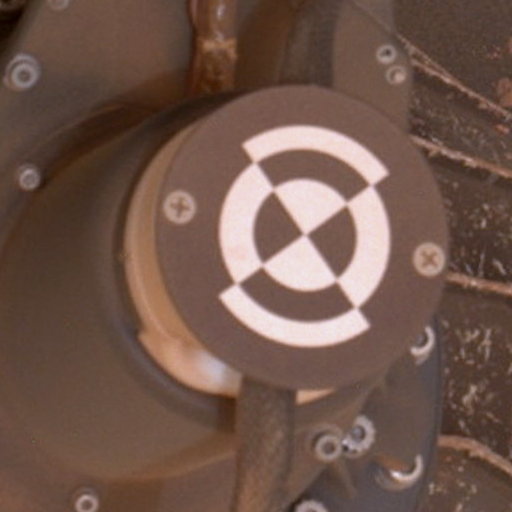

<IPython.core.display.Javascript object>

In [2]:
image = pil_image.open("input/marker_cut_rgb_512.png")
image

## Canny edge detection pipeline consists of 5 steps:
1. Apply Gaussian filter to smooth the image in order to remove the noise
2. Find the intensity gradients of the image
3. Apply non-maximum suppression to get rid of spurious response to edge detection
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

In [3]:
# Process image as numpy array
image_numpy = np.array(image)

<IPython.core.display.Javascript object>

In [4]:
def show(im):
    # Plots numpy array as pil image
    return pil_image.fromarray(im.astype(np.uint8))

<IPython.core.display.Javascript object>

### 1. Gaussian filter
To smooth the image, a Gaussian filter is applied to convolve with the image. 

In [5]:
def gauss_pdf(sigma, x, y):
    return np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)


def gauss_filter(sigma, size=5):
    kernel = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            kernel[i, j] = gauss_pdf(sigma, i - size // 2, j - size // 2)

    return kernel

<IPython.core.display.Javascript object>

In [6]:
f = gauss_filter(1.4)

image_smoothed = utils.convolve_image(image_numpy, f)

<IPython.core.display.Javascript object>

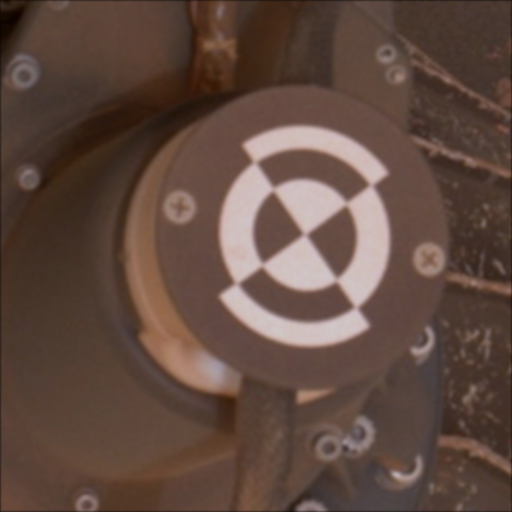

<IPython.core.display.Javascript object>

In [7]:
show(image_smoothed)

### 2. Find the intensity gradients of the image
Use Sobel edge detection operator

In [8]:
def sobel_filters(im):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    channels = im.shape[2]
    Ix = np.sum(utils.convolve_image(im, Kx), axis=2) / channels
    Iy = np.sum(utils.convolve_image(im, Ky), axis=2) / channels

    G = np.hypot(Ix, Iy)

    magnitude = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (magnitude, theta)


magnitude, theta = sobel_filters(image_smoothed)

<IPython.core.display.Javascript object>

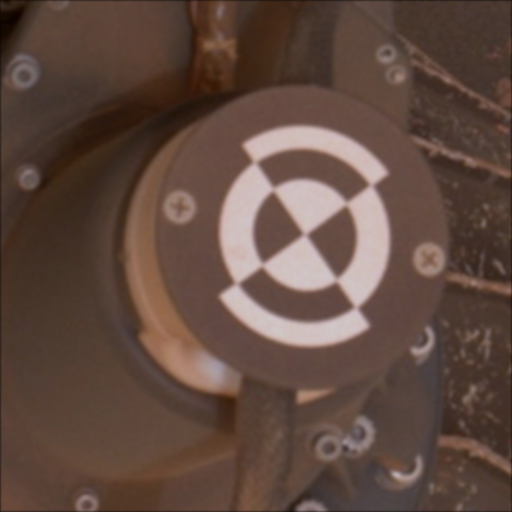

<IPython.core.display.Javascript object>

In [9]:
show(image_smoothed)

###  3. Non-maximum suppression
The edge direction angle is rounded to one of four angles representing vertical, horizontal and the two diagonals (0°, 45°, 90° and 135°).

In [10]:
def round_angle(angle):
    # Angle is rounded to one of four angles (0, PI/4, PI/2 and 3PI/4)
    angle = (angle + np.pi) % np.pi
    if angle < np.pi / 8 or angle > 7 * np.pi / 8:
        return 0
    if angle < np.pi / 8 + np.pi / 4:
        return np.pi / 4
    if angle < np.pi / 8 + np.pi / 2:
        return np.pi / 2
    return 3 * np.pi / 4


def non_max_suppression(magnitude, theta):
    height, width = magnitude.shape
    result = np.zeros(magnitude.shape)

    for i in range(1, width - 1):
        for j in range(1, height - 1):
            angle = round_angle(theta[i, j])
            m = magnitude[i, j]

            if angle == 0:
                # Check east-west directions neighbours magnitude
                m1 = magnitude[i, j + 1]
                m2 = magnitude[i, j - 1]

            if angle == np.pi / 4:
                # Check north east and south west directions
                m1 = magnitude[i + 1, j - 1]
                m2 = magnitude[i - 1, j + 1]
            elif angle == np.pi / 2:
                # Check north and south directions
                m1 = magnitude[i + 1, j]
                m2 = magnitude[i - 1, j]
            else:
                # Check north west and south-east
                m1 = magnitude[i - 1, j - 1]
                m2 = magnitude[i + 1, j + 1]

            if m > m1 and m > m2:
                result[i, j] = m
            else:
                # Magnitude is suppressed
                result[i, j] = 0

    return result


suppressed_magnitude = non_max_suppression(magnitude, theta)

<IPython.core.display.Javascript object>

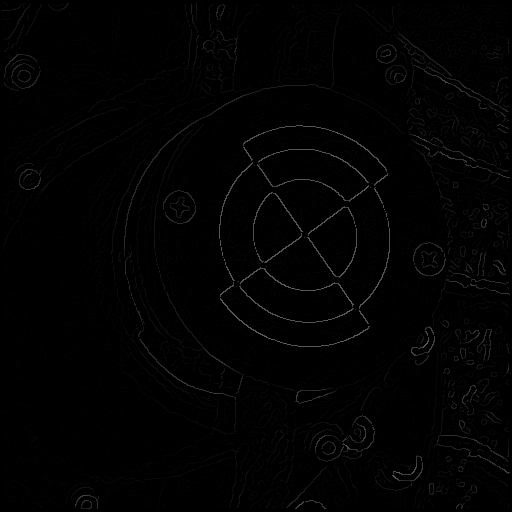

<IPython.core.display.Javascript object>

In [11]:
show(suppressed_magnitude)

### 4. Apply double threshold to determine potential edges

In [12]:
def double_threshold(im, low_ratio=0.05, high_ratio=0.1):
    result = np.zeros(im.shape).astype(np.uint8)

    high_threshold = im.max() * high_ratio
    low_threshold = high_threshold * low_ratio

    high_i, high_j = np.where(im >= high_threshold)
    low_i, low_j = np.where((im >= low_threshold) & (im < high_threshold))

    strong = 255
    weak = 30

    result[high_i, high_j] = strong
    result[low_i, low_j] = weak

    return result, strong, weak


magnitude_thresholded, strong, weak = double_threshold(suppressed_magnitude)

<IPython.core.display.Javascript object>

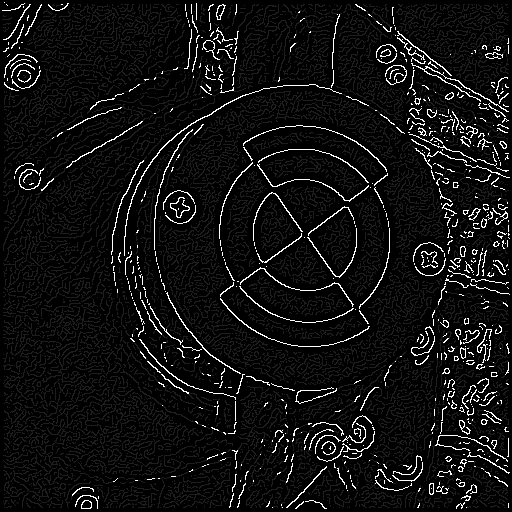

<IPython.core.display.Javascript object>

In [13]:
show(magnitude_thresholded)

### 5. Edge tracking by hysteresis
There are many weak edges on the previous image. 
Hysteresis filters weak edges that are not connected to strong edges

In [14]:
def hysteresis(im, strong, weak):
    result = np.zeros(im.shape)

    for i in range(1, im.shape[0] - 1):
        for j in range(1, im.shape[1] - 1):
            if im[i, j] == strong:
                result[i, j] = strong
            if im[i, j] == weak:
                # Check if some of 8-connected neighbours is strong
                neighbours = np.array(
                    [
                        im[k, l]
                        for k in range(i - 1, i + 2)
                        for l in range(j - 1, j + 2)
                        if not (k == i and l == j)
                    ]
                )
                if np.any(neighbours == strong):
                    result[i, j] = strong
    return result


edges = hysteresis(magnitude_thresholded, strong, weak)

<IPython.core.display.Javascript object>

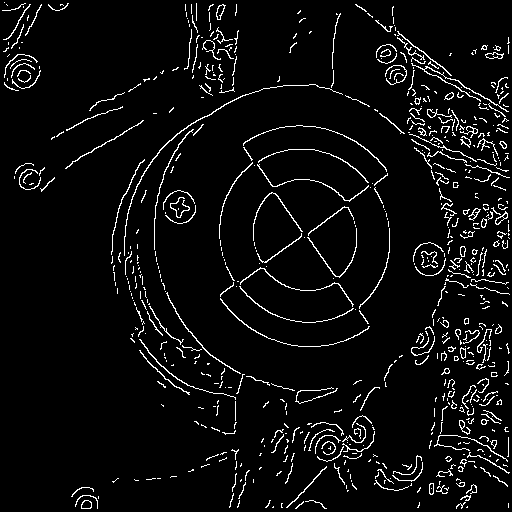

<IPython.core.display.Javascript object>

In [15]:
show(edges)

In [16]:
np.save("edges", edges)

<IPython.core.display.Javascript object>